In [98]:
library("MASS")
library("car")
library('ggplot2')
library('gridExtra')
library('tidyr')
library('repr')
data = read.csv("BodyFat.csv", header = TRUE)[,-1]
attach(data)

### 1. Introduction

Based on a data set consisting of body fat Percentage and other 14 physical measurements of 252 men, a simple linear model is proposed to predict men's body fat. 
<br />
To achieve this goal, several criterions are used, including BIC, AIC, Mallow's Cp, to select important variables. After model diagonstics, some independent variables are transformed to better satisfy the linear model assumptions.
Among all 14 variables, the linear function of `WEIGHT`, `ABDOMEN` can best interpret `BODYFAT`.

### 2.  Data Cleaning

#### 2.1 Exploratory Data Analysis

**Raw data is examined to detect strange records.**
<br />
Here is the boxplots for variable `BODYFAT` and `HEIGHT`.

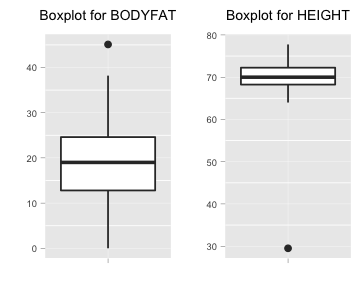

In [99]:
options(repr.plot.width=3, repr.plot.height=2.5, repr.fig.align='center')
g = ggplot(data, mapping = aes('',BODYFAT))
p1 <- g + geom_boxplot() + xlab('') + ylab('') + ggtitle('Boxplot for BODYFAT') +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))
g = ggplot(data, mapping = aes('',HEIGHT))
p2 <- g + geom_boxplot() + xlab('') + ylab('') + ggtitle('Boxplot for HEIGHT') +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))
grid.arrange(p1, p2, ncol=2)
detach(data)
data <- data[c(-182, -42),]
attach(data)

**Form the Boxplot for BODYFAT, two suspicious records stand out:**
* **the one with extremely large `BODYFAT`**: After evaluating other body measurements, his bodyfat value is reasonable, so the record is kept.
* **the one with zero `BODYFAT`**: It is impossible for a human to have $0%$ body fat. Also the `BODYFAT` calculated by `DENSITY` based on Siri's equation is $-3.61$, which is even more ridiculous. So this record is deleted.

**From the Boxplot for HEIGHT, there is one abonormal record:**
* **the one with extremely small `HEIGHT`**: Although this man is extremly short, his `WEIGHT` seems normal as well as all other measurements, which means this man is not disabled or has any illness. Thus, the height is not correct and the record is excluded.

After excluding record No.182 (the zero body fat one) and No.42 (the extremely short one), the general trend of `BODYFAT` versus all other measurements are examined. It seems that all measurments except `HEIGHT` have a positive influence on `BODYFAT` when other variables are fixed. 

#### 2.2 Consistence of BODYFAT versus DENSITY

According to the background meterials, `BODYFAT` and `DENSITY` should satisfy Siri's equation. 
To check Siri's equation, a linear model is fitted: $$ BODYFAT = \beta_{0} + \beta_{1} \frac{1}{DENSITY}$$
Since valid record should fit this linear model quite well, the outliers are suspected to contain some uncorrect values.
Here is the residual plot for $model \ 0$:

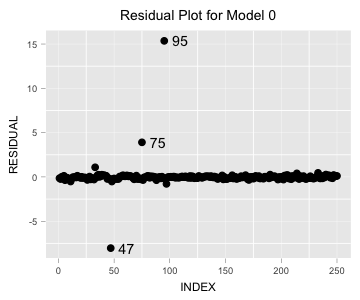

In [100]:
options(repr.plot.width=3, repr.plot.height=2.5, repr.fig.align='center')
reverse_de <- 1/DENSITY
m0 <- lm(BODYFAT ~ reverse_de)
residual <- m0$residuals
d <- data.frame(cbind(index = seq(length(residual)), residual))
ggplot(d, aes(index,residual, label = index)) +
    geom_point() +
    ggtitle('Residual Plot for Model 0') +
    xlab('INDEX') +
    ylab('RESIDUAL') +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))+ 
    geom_text(aes(label = ifelse(abs(residual) > 2, as.character(index),''), hjust = -0.5, vjust = 0.5), size = 3)

**From the residual plot above, three records have relatively large residuals, which indicate abnormaity. **

* **record No.95:** The body fat calculated by `DENSITY` is about 0.4, which is extremely small. Also, compared with other's body measurements, No. 95's measurements are quite normal. Thus, the value of `DENSITY` is likely to be wrong, the original `BODYFAT` value is kept.
* **record No.75:** The `BODYFAT` calculated by `DENSITY` was about 14.1. Compared with No.24's record, which has very similar value of measurements except `AGE`, we argue that the original `BODYFAT` value 18.3 was more reasonable. This is because older people tend to have larger body fat percentage.
* **record No.47:** The `BODYFAT` calculated by `DENSITY` is about 14.1. Compared with No.24's record. Most of their measurements are similar except No.48's `CHEST` is about 3 cm larger, which won't result in a big difference between two men's `BODYFAT`. Thus, the original `BODYFAT` is replaced.

#### 2.3 Consistence of BMI versus HEIGHT and WEIGHT

In this part, the consistence of BMI versus `HEIGHT` and `WEIGHT` is checked based on a standard formula:
$ BMI = \frac{weight (kg)} {height (m)^{2}} $.
If the record is correct, the value of  `ADIPOSITY` should be close enough to the calculated one. 

In [101]:
options(repr.plot.width=3, repr.plot.height=2.5, repr.fig.align='center')
data$WEIGHT <- data$WEIGHT * 0.453592
data$HEIGHT <- data$HEIGHT * 0.0254
detach(data)
attach(data)

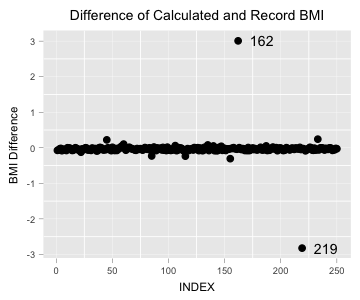

In [102]:
BMI <- WEIGHT/(HEIGHT^2)
diff <- BMI - ADIPOSITY
d <- data.frame(cbind(index = seq(length(residual)), diff))
ggplot(d, aes(index,diff, label = index)) +
    geom_point() +
    ggtitle('Difference of Calculated and Record BMI') +
    xlab('INDEX') +
    ylab('BMI Difference') +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))+ 
    geom_text(aes(label = ifelse(abs(diff) > 2, as.character(index),''), hjust = -0.5, vjust = 0.5), size = 3)

**From the Difference Plot above, there are two abnormal points: No.162, No.219:**
* **record No.162:** Compared with record No.19 which have similar `HEIGHT` and `WEIGHT`, No.162 has smaller chest, larger Abdomen circumference and smaller biceps circumference. All of these indicate a larger bodyfat which is not the case. Thus, there is  something wrong with `HEIGHT` or `WEIGHT` value for record  No.162. However, it's hard to tell which one is wrong so the record is excluded.
* **record No.219:** Compared with No.218, No. 219 is lighter and higher with smaller `BODYFAT`, larger `WRIST` and `ANKLE` value, which means No.219 has more fat and smaller bone. however, most measurements of No.219 is larger than No.218, which make no sense. So the record is excluded.

In [103]:
detach(data)
data <- data[-c(162, 219),-2]
attach(data)

### 3. Variable Selection

The following table displays the number of selected variables and their corresponding methods.

| Method               | Selected Varibles               | Method               | Selected Varibles               |
| :--------------------| :-----------------------------: | :--------------------| :-----------------------------: |  
| BIC Backward         | WEIGHT, ABDOMEN, FOREARM, WRIST | AICForward  & Both   | 6 variables                     |
| BIC  Forward  & Both | ABDOMEN, WEIGHT                 | Mallow's Cp          | 9 variables                     |
| AIC Backward         | 10 variables                    | LASSO                | 5 variables                     | 


To further evaluate the selected models, ANOVA is performed on $full\ model$ versus all selected ones. 
<br \>
It turns out that the four variables model (denoted as $model\ 1$) is good enough and has no significant difference between $full\ model$. 
<br \>
Here is the anova result for $model \ 1$ versus $full \ model$:
<br \>
P-value for this test is $0.107$, so the null hypothesis is retained.
<br \>
Also for two variables model (denote as $model \ 2$) versus $full \ model$, the result is shown below:

In [104]:
m_full <- lm(BODYFAT ~., data)
m1 <- lm(BODYFAT ~ WEIGHT + FOREARM + ABDOMEN + WRIST) 
m2 <- lm(BODYFAT ~ WEIGHT + ABDOMEN)

The p-value is about $0.0045$ and null hypothesis is rejected.

Since the main goal for this project is to develop a **simple** model, both $model \ 1$ and $model \ 2$ are kept for further improvement and comparison

### 4. Model Diagnostic
#### 4.1 Diagnostic for Model 1
**4.1.1 Evaluation of Diagnose Plot**
**Plot interpretation and corresponding test**
* **For Residual Plot**: there is no wried pattern and the points are randomly dispersed around the horizontal axis, thus the linear regression model seems to be appropriate for the data.
* **For Q-Q plot**: the points fall on the 45-degree reference line which indicate standardized residual follows standard normal distribution.


**4.1.2 Formal Assumption Test**

Apart from diagnostic plot, we also used some other tests to double-check linear model assumptions.
<br \>
* **Normality Assumption**
<br \>
$H_{0}:$ The population is normally distributed.

In [105]:
shapiro.test(m1$residuals)


	Shapiro-Wilk normality test

data:  m1$residuals
W = 0.98948, p-value = 0.06853


According to p-value which is larger than $0.05$, $H_{0}$ is retained.
<br \>
* **Multi-collinearity Test**

| Variable          | VIF  | Variable     | VIF             |
| :-----------------| :--: | :----------: | :-------------: | 
| WEIGHT            | 7.16 |FOREARM       |1.77             |
| ABDOMEN           | 4.84 |WRIST         |2.31             |

The variance inflation factor for all variables in $model \ 1$ is smaller than 10, thus the model doesn't have serious multi-collinearity problem.

* **Homoscedasticity Test**
<br \>
$H_{0}:$ The tested model has constant error variance 

In [106]:
ncvTest(m1)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.05194751    Df = 1     p = 0.8197085 

From the test result above, p-value is larger than $0.05$ which means $H_{0}$ is retained.
<br \>
* **linearity test**
<br \>
From the partial residual plot generated, the fitted lowess line of `WEIGHT` has a relatively large deviation to the ls line. Thus the  linearity assumption may not be satisified.
To improve the model, box-cox transformation is performed for variable `WEIGHT` and the new model denoted as $model \ 3$: 

$$ BODYFAT(\%) = 30 - 0.5 WEIGHT (kg) + 0.9 ABDOMEN (cm) + 0.2 FOREARM (cm) - 1.3 WRIST (cm) - 766.5 WEIGHT^{-0.7}$$

Here is the result of linearty test for $model\ 3$:


In [107]:
W2 <- WEIGHT^(-0.707070707070708)
m3<- lm(BODYFAT ~ ABDOMEN + WEIGHT + FOREARM + WRIST + W2)

| Test                   | Null hypothesis                   |p-value  |Multi-collinearity Test (VIF)               |
| :----------------------| :-------------------------------: | :-----: | :---------------------------------------:  |
| Normality Test         | residual is normally distributed  |0.193    |WEIGHT 22.33    Transformed WEIGHT 21.70    |
| Homoscedasticity Test  | error's variance is constant      |0.469    |FOREARM 1.96    ABDOMEN 4.83    WRIST  2.30 |

All tests are passed, so $model \ 3$ satisfies all necessary assumptions for linear model.
#### 4.2 Diagnostic for Model 2

The diagnostic process for $model \ 2$ is similar. All tests except linearity test are passed. The results are shown below: 

| Test                   | Null hypothesis                   |p-value      | Multi-collinearity Test (VIF)     |
| :----------------------| :-------------------------------: | :---------: | :-------------------------------: | 
| Normality Test         | residual is normally distributed  |0.2689       |WEIGHT 4.68                        |
| Homoscedasticity Test  | error's variance is constant      |0.8069476    |ABDOMEN 4.68                       |

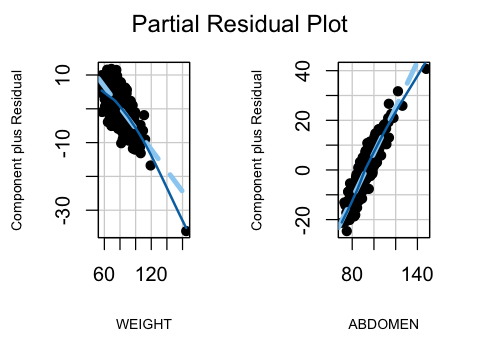

In [108]:
options(repr.plot.width=4, repr.plot.height=3, repr.fig.align='center')
col <- c("#000000", "#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
crPlots(m2, ylab = 'Component plus Residual',main = 'Partial Residual Plot',
            col.lines = c(col[4], col[5]), pch = 19, lwd = 4, grid = TRUE,
            cex.lab = 0.7, cex.main = 0.05)

Since the linearity assumption doesn't satisfied, `WEIGHT` is transformed and the improved model is denoted as $model \ 4$. <br \>
Then according to partial residual plot, $model \ 4$ satisfied linearity assumption. It also passed all other tests.
Here is the test results for $model \ 4$:

| Test                   | Null hypothesis                   |p-value      | Multi-collinearity Test (VIF)  |
| :----------------------| :-------------------------------: | :---------: | :----------------------------: |
| Normality Test         | residual is normally distributed  |0.3292       | ABDOMEN 4.64 WEIGHT 21.87      |
| Homoscedasticity Test  | error's variance is constant      |0.4086975    | Transformed WEIGHT 19.02       |

### 5. Model Comparison and Outlier Detection

From all of the analysis above, four models are obtained. The adjusted-R square are: 0.7294  ($model\ 1$), 0.7168      ($model\ 3$), 0.7398 ($model\ 2$) and <br\>0.729($model\ 4$). Since our main goal for this project is to predict bodyfat, and these adjusted-R square are similar enough, we decided to use $model \ 2$ as our final model:
<br\ >
$$ BodyFat (\%) = -40.80 - 0.31Weight (kg) + 0.92Abdomen (cm) $$
<br\ >
Here is the model coefficients, all variables are significant.

In [109]:
summary(m2)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-40.7971089,2.40762355,-16.944970,3.757215e-43
WEIGHT,-0.3106853,0.04225617,-7.352424,2.907411e-12
ABDOMEN,0.9184448,0.05223807,17.581906,2.590109e-45


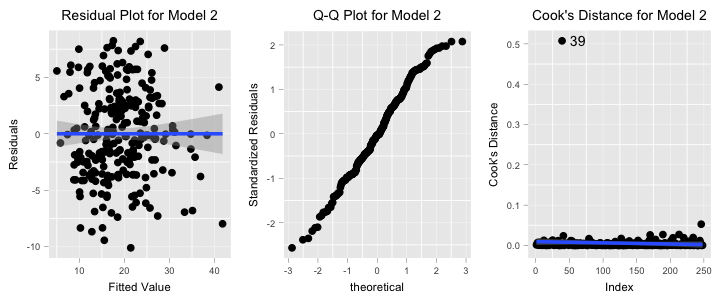

In [110]:

options(repr.plot.width=6, repr.plot.height=2.5, repr.fig.align='center')
res <- m1$residuals
fit <- m1$fitted.values
d <- data.frame(cbind(res, fit))
p1 <- ggplot(d, aes(fit, res)) +
    geom_point() +
    geom_smooth(method = 'lm') + 
    labs(title = 'Residual Plot for Model 2', x = 'Fitted Value', y = 'Residuals') +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))
standres <- data.frame(sample = rstandard(m1))
p2 <- ggplot(standres, aes(sample = sample)) +
    geom_point(stat = "qq") +
    ggtitle('Q-Q Plot for Model 2') + 
    ylab("Standardized Residuals") +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))
d <- data.frame(index = seq(dim(data)[1]), cookd = cooks.distance(m2))
p3 <- ggplot(d, aes(index, cookd)) +
    geom_point() +
    geom_smooth(method = 'lm') + 
    labs(title = 'Cook\'s Distance for Model 2', x = 'Index', y = 'Cook\'s Distance') +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))+
    geom_text(aes(label = ifelse(abs(cookd) > 0.4, as.character(index),''), hjust = -0.5, vjust = 0.5), size = 3)
                
grid.arrange(p1, p2, p3, ncol=3)

**Plot interpretation**
* **For Residual Plot**: there is no wried pattern and the points are randomly dispersed around the horizontal axis, thus the linear regression model seems to be appropriate for the data.
* **For Q-Q plot**: the points fall on the 45-degree reference line which indicate standardized residual follows standard normal distribution.
* **For cook's distance plot** there exist one abnormal point No.39. However, his measurements seems reasonable. So No.39 is kept.

### 6. rules of thumb

                     "multiply your weight (kg) by $0.3$, add your abdomen (cm) and minus $50$"

$$ BODYFAT = 0.3{WEIGHT} + {ABDOMEN} - 50 $$

**Example Usage:**

For a 80 kg man with abdomen circumference about 90 cm, his predicted body fat percentage would be around 17%. There is a 95% probability that his body fat is between 16.5% and 17.5%. Using the simpule of thumb, get about 16% as the predicted body fat.


### 7. Strengths and Weaknesses

The model is a reasonable model between body fat % and abdomen, weight. Moreover, the model has the following strengths:

1. **Explanatory variables**: reasonable since it's easy to think one’s body fat with his weight and abdomen. Intuitively, if a man has a large abdomen circumference, he tends to be fatter and with larger body fat percentage. Meanwhile, if his is heavier given other body measurements fixed, he is likely to be more muscular. Since fat has smaller density. 

2. **Constant effects**: reasonable because it is not affected by age or non-body factors. 

3. **Normally distributed errors**: seems reasonable from the Q-Q plot diagnostic and also the model passed Shapiro-Wilk’s test. 

4. **Constant variance**: the model passed the score test for non-constant error variance. Overall, our model provides a relatively simple way of predict body fat % purely based on weight and abdomen.

5. **Unit consistence**: The units for weight and abdomen are kg and cm, which are under the same system. It will be more convenient to use.

6. The proposed model is quite **simple** with a **good adjust R square value**.

Last but not least, there still exists some potential weaknesses or questions.

1. The model doesn't satisfy linearity assumption.

2. The data was only collected for men, and therefore the model is only suitable for men. Does there exist a general formula for both men and women?

**Contribution and Reference**

**Data cleaning**: Xinjie Ye, Jianxiong Wang, Yiqiao Zhang, Jia Liu
<br \>
**Model fitting**: Xinjie Ye, Jianxiong Wang, Yiqiao Zhang, Jia Liu
<br \>
**Summary**: Xinjie Ye, Jianxiong Wang : **Slides**: Yiqiao Zhang, Jia Liu

[1] Body fat percentage, Wikipedia, https://en.wikipedia.org/wiki/Body_fat_percentage
<br \>
[2] QuickStats: Mean Percentage Body Fat, by Age Group and Sex --- National Health and Nutrition Examination Survey, United States, 1999--2004